# Model Evaluation: Machine Learning Algorithms

## Importing Relevant Libraries

In [ ]:
import spacy

In [ ]:
!python -m spacy download en_core_web_lg

2022-11-12 09:48:39.029177: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 7.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Ml_course/Complaint_prioritization/Data/processed_new.csv', 
                 usecols=['new_processed', 'Priority'])
df.head(3)

,Priority,new_processed
0,High,claim assign hacker send message login page st...
1,High,log td check old charge able money cash money ...
2,High,hi receive email chime debit card send address...


In [8]:
df.isnull().sum()

Priority           0
new_processed    359
dtype: int64

In [9]:
df.dropna(inplace=True)

## Spacy Vectorization

In [ ]:
df['spacy_vector'] = df['new_processed'].apply(lambda text: nlp(text).vector)

In [ ]:
df.head(3)

,Priority,new_processed,spacy_vector
0,High,claim assign hacker send message login page st...,"[-0.4377644, -0.4322528, -0.6407873, 0.3318105..."
1,High,log td check old charge able money cash money ...,"[0.22619864, 1.5457052, -4.27388, 0.45616582, ..."
2,High,hi receive email chime debit card send address...,"[0.26898128, 0.23141298, 0.8945184, -0.1413316..."


In [ ]:
le = LabelEncoder()
target_encode_fit = le.fit(df["Priority"])

In [ ]:
y = target_encode_fit.transform(df["Priority"])

In [ ]:
X = df['spacy_vector']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, test_size=0.2, 
                                                    stratify=y)

### Metric Funcions

In [ ]:
metric_info = {'Model_name':[], 
               'Accuracy': [], 
               'Precision': [], 
               'Recall': [], 
               'F1_score': []}

In [ ]:
def store_metrics(metric_list):
    for key, info in zip(metric_info, metric_list):
        metric_info[key].append(info)

In [ ]:
def print_metrics(name, y_pred, test_labels):
    
    accuracy = np.round(accuracy_score(test_labels, y_pred), 5) * 100
    precision = np.round(precision_score(test_labels, y_pred, average='macro'), 5) * 100
    recall = np.round(recall_score(test_labels, y_pred, average='macro'), 5) * 100
    f1 = np.round(f1_score(test_labels, y_pred, average='macro'), 5) * 100
    conf_matrix = confusion_matrix(test_labels, y_pred)

    print(f'\nAccuracy score: {accuracy}')
    print(f'\nPrecision score: {precision}')
    print(f'\nRecall score: {recall}')
    print(f'\nF1-Score: {f1}')
    print(f'\nConfusion Matrix: \n\n{conf_matrix}')

    store_metrics([name, accuracy, precision, recall, f1])

In [ ]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
mx_scale = MinMaxScaler()

In [ ]:
scaled_fit = mx_scale.fit(X_train_2d)
scaled_train = scaled_fit.transform(X_train_2d)
scaled_test = scaled_fit.transform(X_test_2d)

### Naive Bayes Model

In [ ]:
nbc = MultinomialNB()

In [ ]:
spacy_nbc_model = nbc.fit(scaled_train, y_train)
spacy_nbc_pred = spacy_nbc_model.predict(scaled_test)

In [ ]:
print_metrics('NBC-Spacy',spacy_nbc_pred)


Accuracy score: 51.54600000000001

Precision score: 51.365

Recall score: 40.300000000000004

F1-Score: 35.311

Confusion Matrix: 

[[3887    0  600]
 [ 984    1  664]
 [2751    1 1431]]


### Support Vector Classifier

In [ ]:
supp_vect = SVC()

In [ ]:
spacy_svc_model = supp_vect.fit(scaled_train, y_train)
spacy_svc_pred = spacy_svc_model.predict(scaled_test)

In [ ]:
print_metrics('SVC-Spacy', spacy_svc_pred)


Accuracy score: 64.88000000000001

Precision score: 64.67

Recall score: 59.936

F1-Score: 61.402

Confusion Matrix: 

[[3363  137  987]
 [ 337  686  626]
 [1298  239 2646]]


### Random Forest Classifier

In [ ]:
rfc_spacy = RandomForestClassifier()

In [ ]:
spacy_rfc_model = rfc_spacy.fit(scaled_train, y_train)
spacy_rfc_pred = spacy_rfc_model.predict(scaled_test)

In [ ]:
print_metrics('RFC-Spacy', spacy_rfc_pred)


Accuracy score: 61.400999999999996

Precision score: 61.671

Recall score: 55.462

F1-Score: 56.913000000000004

Confusion Matrix: 

[[3334   97 1056]
 [ 453  553  643]
 [1506  228 2449]]


### Logistic Regression

In [ ]:
lr_spacy = LogisticRegression(max_iter=1000)

In [ ]:
spacy_lr_model = lr_spacy.fit(scaled_train, y_train)
spacy_lr_pred = spacy_lr_model.predict(scaled_test)

In [ ]:
print_metrics('LR-Spacy', spacy_lr_pred)


Accuracy score: 63.514

Precision score: 62.544

Recall score: 58.475

F1-Score: 59.729

Confusion Matrix: 

[[3352  139  996]
 [ 361  658  630]
 [1346  293 2544]]


In [ ]:
metric_info

{'Model_name': ['NBC-Spacy', 'SVC-Spacy', 'RFC-Spacy', 'LR-Spacy'],
 'Accuracy': [51.54600000000001,
  64.88000000000001,
  61.400999999999996,
  63.514],
 'Precision': [51.365, 64.67, 61.671, 62.544],
 'Recall': [40.300000000000004, 59.936, 55.462, 58.475],
 'F1_score': [35.311, 61.402, 56.913000000000004, 59.729]}

## TFIDF Vectorization

In [ ]:
metric_info = {'Model_name': ['NBC-Spacy', 'SVC-Spacy', 'RFC-Spacy', 'LR-Spacy'], 
               'Accuracy': [51.546, 64.88, 61.401, 63.514],
               'Precision': [51.365, 64.67, 61.671, 62.544],
               'Recall': [40.30, 59.936, 55.462, 58.475], 
               'F1_score': [35.311, 61.402, 56.913, 59.729]}

In [10]:
df.head()

,Priority,new_processed
0,High,claim assign hacker send message login page st...
1,High,log td check old charge able money cash money ...
2,High,hi receive email chime debit card send address...
3,High,allow fraudulent transaction notify email phon...
4,High,payment find scam want help reverse payment tr...


In [11]:
X = df['new_processed']
y = df['Priority'].map({'High': 0, 'Medium': 1, 'Low': 2})

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

In [13]:
tfidf = TfidfVectorizer()

In [14]:
tfidf_fit = tfidf.fit(X_train)

In [15]:
X_train_tfidf = tfidf_fit.transform(X_train)

In [16]:
X_test_tfidf = tfidf_fit.transform(X_test)

### SVC

In [ ]:
svc_tfidf = SVC()

In [ ]:
model_svc_tfidf = svc_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
svc_tfidf_pred = model_svc_tfidf.predict(X_test_tfidf)

In [ ]:
print_metrics('SVC-TFIDF', svc_tfidf_pred, y_test)


Accuracy score: 67.381

Precision score: 66.97800000000001

Recall score: 63.471999999999994

F1-Score: 64.744

Confusion Matrix: 

[[3434  912  141]
 [1202 2709  272]
 [ 307  532  810]]


### SVC-Sigmoid kernel

In [ ]:
svc_tfidf_sig = SVC(kernel='sigmoid')

In [ ]:
model_svc_tfidf_sig = svc_tfidf_sig.fit(X_train_tfidf, y_train)

In [ ]:
svc_tfidf_sig_pred = model_svc_tfidf_sig.predict(X_test_tfidf)

In [ ]:
print_metrics('SVC(sig)-TFIDF', svc_tfidf_sig_pred, y_test)


Accuracy score: 65.375

Precision score: 64.278

Recall score: 61.312999999999995

F1-Score: 62.375

Confusion Matrix: 

[[3402  937  148]
 [1274 2577  332]
 [ 324  558  767]]


### Naive-Bayes

In [ ]:
nbc_tfidf = MultinomialNB()

In [ ]:
model_nbc_tfidf = nbc_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
nbc_tfidf_pred = model_nbc_tfidf.predict(X_test_tfidf)

In [ ]:
print_metrics('NBC-TFIDF', nbc_tfidf_pred, y_test)


Accuracy score: 61.789

Precision score: 63.243

Recall score: 51.931000000000004

F1-Score: 51.812000000000005

Confusion Matrix: 

[[3410 1040   37]
 [1376 2724   83]
 [ 366 1041  242]]


### Logistic Regression

In [ ]:
lr_tfidf = LogisticRegression(max_iter=1000)

In [ ]:
model_lr_tfidf = lr_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
lr_tfidf_pred = model_lr_tfidf.predict(X_test_tfidf)

In [ ]:
print_metrics('LR-TFIDF', lr_tfidf_pred, y_test)


Accuracy score: 65.917

Precision score: 65.098

Recall score: 61.878

F1-Score: 63.031000000000006

Confusion Matrix: 

[[3409  940  138]
 [1252 2616  315]
 [ 321  551  777]]


### Random Forest Classifier

In [ ]:
rfc_tfidf = RandomForestClassifier()

In [ ]:
model_rfc_tfidf = rfc_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
rfc_tfidf_pred = model_rfc_tfidf.predict(X_test_tfidf)

In [ ]:
print_metrics('RFC-TFIDF', rfc_tfidf_pred, y_test)


Accuracy score: 64.405

Precision score: 64.92099999999999

Recall score: 57.272

F1-Score: 58.711

Confusion Matrix: 

[[3491  909   87]
 [1370 2649  164]
 [ 383  760  506]]


## Comparison of Metrics

In [ ]:
metric_df = pd.DataFrame(metric_info, index=metric_info['Model_name'], columns = list(metric_info.keys())[1:])
metric_df

,Accuracy,Precision,Recall,F1_score
NBC-Spacy,51.546,51.365,40.300,35.311
SVC-Spacy,64.880,64.670,59.936,61.402
RFC-Spacy,61.401,61.671,55.462,56.913
LR-Spacy,63.514,62.544,58.475,59.729
SVC-TFIDF,67.381,66.978,63.472,64.744
SVC(sig)-TFIDF,65.375,64.278,61.313,62.375
NBC-TFIDF,61.789,63.243,51.931,51.812
LR-TFIDF,65.917,65.098,61.878,63.031
RFC-TFIDF,64.405,64.921,57.272,58.711


In [ ]:
train_sizes, train_scores, test_scores = learning_curve(svc_tfidf, 
                                                                X_train_tfidf, y_train, 
                                                                cv=5, 
                                                                verbose=3)

[learning_curve] Training set sizes: [ 3301 10730 18159 25588 33017]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................., score=(train=0.938, test=0.636) total time=  22.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s remaining:    0.0s


[CV] END ..................., score=(train=0.907, test=0.650) total time= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] END ..................., score=(train=0.895, test=0.658) total time= 7.5min
[CV] END ..................., score=(train=0.887, test=0.660) total time=19.5min
[CV] END ..................., score=(train=0.884, test=0.666) total time=33.8min
[CV] END ..................., score=(train=0.935, test=0.645) total time=  22.1s
[CV] END ..................., score=(train=0.906, test=0.660) total time= 2.3min
[CV] END ..................., score=(train=0.896, test=0.667) total time= 7.8min
[CV] END ..................., score=(train=0.886, test=0.669) total time=20.0min
[CV] END ..................., score=(train=0.882, test=0.669) total time=34.8min
[CV] END ..................., score=(train=0.935, test=0.640) total time=  21.7s
[CV] END ..................., score=(train=0.906, test=0.654) total time= 2.3min
[CV] END ..................., score=(train=0.893, test=0.662) total time= 7.8min
[CV] END ..................., score=(train=0.886, test=0.665) total time=20.1min
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 438.0min finished


In [ ]:
learning_curve_df = pd.DataFrame({ 'Train_accuracy': train_scores.mean(axis=1), 
                                  'Test_accuracy': test_scores.mean(axis=1)})
learning_curve_df

,Train_accuracy,Test_accuracy
0,0.935474,0.640870
1,0.906039,0.653882
2,0.894245,0.661611
3,0.886994,0.662774
4,0.883133,0.665003


In [ ]:
learning_curve_df.to_csv('/content/drive/MyDrive/Ml_course/Complaint_prioritization/acc_scores.csv', 
                          index=False)

In [ ]:
learning_curve_df = pd.read_csv('/content/drive/MyDrive/Ml_course/Complaint_prioritization/acc_scores.csv')

In [ ]:
svc_tfidf_loss = SVC(probability=True)

In [ ]:
train_sizes_2, train_loss, test_loss = learning_curve(svc_tfidf_loss, 
                                                      X_train_tfidf, 
                                                      y_train, 
                                                      cv=5, 
                                                      scoring='neg_log_loss', 
                                                      train_sizes=np.linspace(0.3, 0.5, 5), 
                                                      verbose=3)

[learning_curve] Training set sizes: [ 9905 11555 13206 14857 16508]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................., score=(train=-0.369, test=-0.787) total time= 3.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV] END ................., score=(train=-0.376, test=-0.782) total time= 5.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.3min remaining:    0.0s


[CV] END ................., score=(train=-0.381, test=-0.778) total time= 6.9min
[CV] END ................., score=(train=-0.383, test=-0.776) total time= 9.1min
[CV] END ................., score=(train=-0.386, test=-0.775) total time=11.9min
[CV] END ................., score=(train=-0.376, test=-0.775) total time= 3.8min
[CV] END ................., score=(train=-0.382, test=-0.771) total time= 5.3min
[CV] END ................., score=(train=-0.388, test=-0.769) total time= 7.0min
[CV] END ................., score=(train=-0.389, test=-0.767) total time= 9.3min
[CV] END ................., score=(train=-0.394, test=-0.763) total time=11.8min
[CV] END ................., score=(train=-0.370, test=-0.786) total time= 3.8min
[CV] END ................., score=(train=-0.378, test=-0.781) total time= 5.2min
[CV] END ................., score=(train=-0.381, test=-0.779) total time= 6.5min
[CV] END ................., score=(train=-0.387, test=-0.777) total time= 8.7min
[CV] END ................., 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 206.2min finished


In [ ]:
train_loss.mean(axis=1) * -1

array([0.37090566, 0.37861213, 0.38414444, 0.38564275, 0.39176737])

In [ ]:
learning_curve_df['Train_loss'] = train_loss.mean(axis=1) * -1
learning_curve_df['Test_loss'] = test_loss.mean(axis=1) * -1

In [ ]:
learning_curve_df

,Train_accuracy,Test_accuracy,Train_loss,Test_loss
0,0.935474,0.640870,0.370906,0.782770
1,0.906039,0.653882,0.378612,0.779337
2,0.894245,0.661611,0.384144,0.776841
3,0.886994,0.662774,0.385643,0.775108
4,0.883133,0.665003,0.391767,0.772562


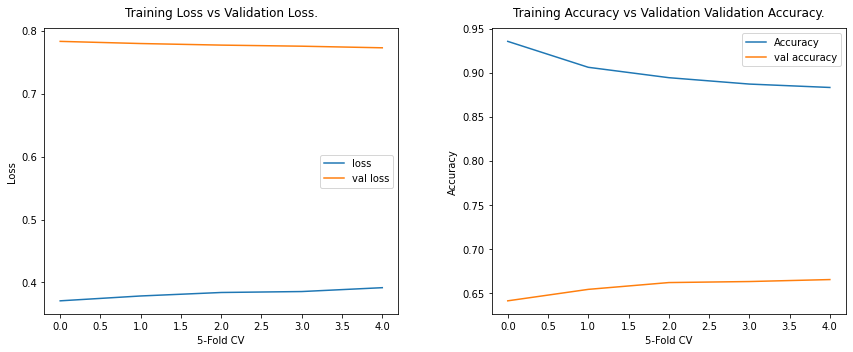

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(learning_curve_df[['Train_loss', 'Test_loss']])
plt.legend(['loss', 'val loss'])
plt.title('Training Loss vs Validation Loss.', pad=12)
plt.xlabel('5-Fold CV')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(learning_curve_df[['Train_accuracy', 'Test_accuracy']])
plt.legend(['Accuracy', 'val accuracy'])
plt.title('Training Accuracy vs Validation Validation Accuracy.', pad=12)
plt.xlabel('5-Fold CV')
plt.ylabel('Accuracy')

plt.tight_layout(w_pad=5)

****************